# Experimenting the LIME Model for Explainability (XAI)

In [22]:
import lime
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow_probability as tfp

## Fetching the Sample Dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

In [3]:
# Feature extraction from text
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

In [4]:
train_vectors.shape, test_vectors.shape

((1079, 23035), (717, 23035))

In [6]:
assert train_vectors.shape[1] == test_vectors.shape[1], "Train and test vectors must have the same number of features"

## Train a simple TensorFlow Model for Proof-of-Concept

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(train_vectors.shape[1],))) # number of features
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_vectors.toarray(), newsgroups_train.target,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9769 - val_loss: 0.0735
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9769 - val_loss: 0.0722
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9769 - val_loss: 0.0713
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9769 - val_loss: 0.0702
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9769 - val_loss: 0.0698


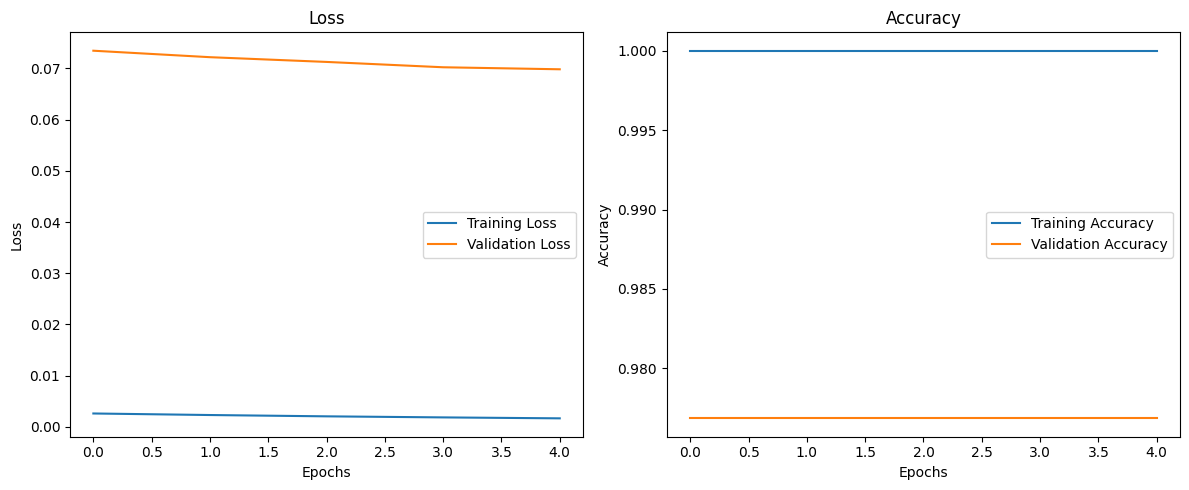

In [14]:
# Extract loss and accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Make Predictions with the Sample Model

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


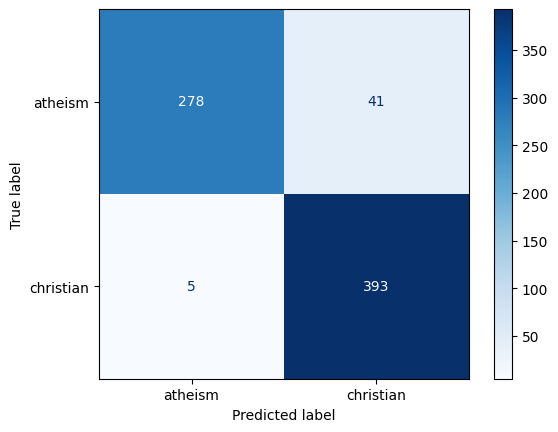

In [17]:
pred = model.predict(test_vectors.toarray())
pred_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(newsgroups_test.target, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Explaining with LIME

In [19]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, model)

In [ ]:
# Custom Predict Proba with tensorflow's probability
# https://www.tensorflow.org/probability
def custom_predict_proba(texts):
    vectors = vectorizer.transform(texts)  # Transform the input texts
    predictions = model.predict(vectors.toarray())  # Get predictions from the model
    return predictions

In [30]:
c.predict_proba = custom_predict_proba

In [35]:
for i in range(len(newsgroups_test.data)):
    if (i<10):
        print(c.predict_proba([newsgroups_test.data[i]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.77677333 0.22322665]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.18418327 0.81581676]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.9984114  0.00158851]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.01364955 0.9863505 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.5078112  0.49218878]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.03223222 0.9677678 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.00240413 0.99759585]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.00462248 0.99537754]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.01831613 0.9816838 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.9022809  0.09771905]]


In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
explainer

In [46]:
# Ensure the input text is a string
newsgroups_test.data = [str(doc) for doc in newsgroups_test.data]

exp = explainer.explain_instance(
    newsgroups_test.data[0], c.predict_proba, num_features=10
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [47]:
exp.as_list()

[(np.str_('au'), -0.11732051363764577),
 (np.str_('am'), 0.09835526835973339),
 (np.str_('guy'), -0.08643599308653967),
 (np.str_('request'), -0.06800448002102764),
 (np.str_('Eng'), 0.06098256283641338),
 (np.str_('copy'), -0.05732038011479554),
 (np.str_('wrote'), -0.053633022896405896),
 (np.str_('Adelaide'), -0.04077431894645283),
 (np.str_('adelaide'), -0.03830148170783035),
 (np.str_('oz'), 0.03407065189286778)]

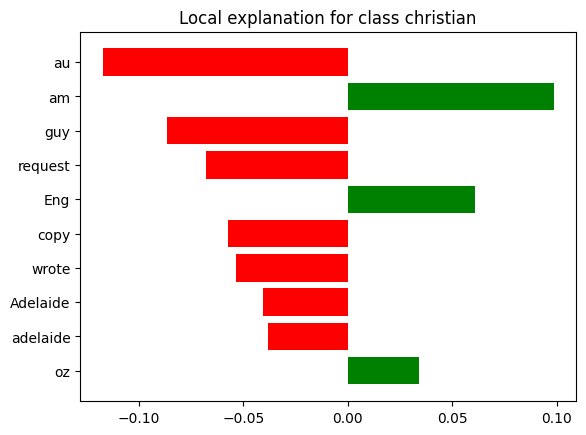

In [52]:
%matplotlib inline
fig = exp.as_pyplot_figure()